In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skellam

# Simulation of a sample path for the Skellam-INGARCH

In [2]:
def skellam_ingarch(omega,alpha,beta,r,sample_size):
    eps = .001
    
    mu = [eps]
    r_factor = .5*(3*r-1)/(r+1)
    state_var = abs(mu[-1]) * (r_factor + .5*np.sign(mu[-1])*np.array([1,-1]))
    
    Y = [skellam.rvs(state_var[0],state_var[1],1)]
    
    for time in range(1,sample_size):
        new_mu = omega + alpha*Y[-1]+beta*mu[-1]
        state_var = abs(mu[-1])*( r_factor + .5*np.sign(mu[-1])*np.array([1,-1]))
        new_y = np.random.poisson(state_var[0]) - np.random.poisson(state_var[1])
#         new_y = skellam.rvs(state_var[0], state_var[1], 1)
        
        mu.append(new_mu)
        Y.append(new_y)
    return pd.DataFrame({'obs':Y, 'mu':mu})

In [3]:
sim_df = skellam_ingarch(-1, .1,.7, 2 ,50 )

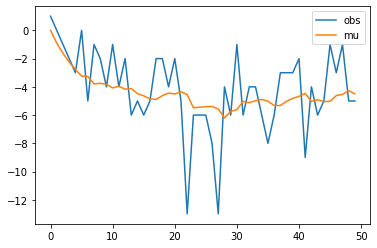

In [4]:
sim_df.plot()

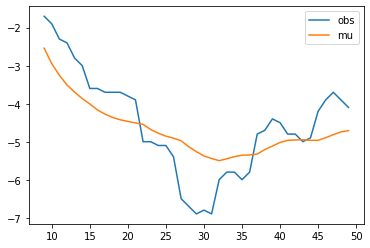

In [5]:
sim_df.rolling(window = 10).mean().plot()

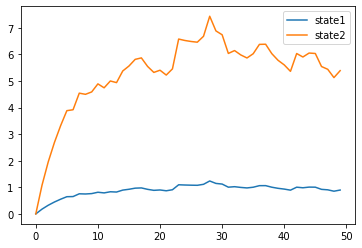

In [6]:
r = 1.5
r_factor = .5*(3*r-1)/(r+1)
state_df = pd.DataFrame(columns = ['state1','state2'])


state_df['state1'] = sim_df['mu'].apply(lambda s: abs(s)*(r_factor + .5*np.sign(s)) )
state_df['state2'] =sim_df['mu'].apply(lambda s: abs(s)*(r_factor - .5*np.sign(s)) )

state_df.plot()

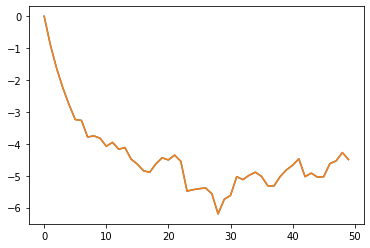

In [7]:
fig, ax = plt.subplots()

(state_df['state1']-state_df['state2']).plot(ax = ax)
sim_df['mu'].plot(ax=ax)

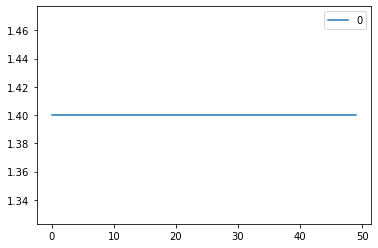

In [8]:
pd.DataFrame((state_df.sum(axis=1))/np.abs((state_df['state1']-state_df['state2']))).plot()

# Maximum likelihood estimation

In [9]:
def skellam_filter(c,a,b,r,Y):
    sample_size = len(Y)

    mu_est = [Y[0]]
    for time in range(1,sample_size):
        new_mu_est = c+a*Y[time] + b*mu_est[-1]
        mu_est.append(new_mu_est)
    
    filter_df = pd.DataFrame({'obs':Y, 'mu_est':mu_est})
    filter_df['mu_est'] = filter_df['mu_est'].shift(1)
    filter_df = filter_df.dropna()
    
    r_factor = .5*(3*r-1)/(r+1)
    filter_df['state1'] = filter_df['mu_est'].apply(lambda s: abs(s)*(r_factor + .5*np.sign(s)) )
    filter_df['state2'] =filter_df['mu_est'].apply(lambda s: abs(s)*(r_factor - .5*np.sign(s)) )
    
    return filter_df

In [10]:
def skellam_log_likelihood(theta,Y):
    c,a,b,r = theta
    est_df = skellam_filter(c,a,b,r,Y)
    est_df['log_like'] = est_df.apply(lambda s: np.log(skellam(s[2],s[3]).pmf(s[0]) ), axis =1   )
    
    log_likelihood = est_df['log_like'].mean()
    return -log_likelihood

In [11]:
Y = sim_df['obs']
def skellam_fixed_ll(theta):
    return skellam_log_likelihood(theta,Y)

In [12]:
from scipy.optimize import minimize
res = minimize(skellam_fixed_ll, x0 = [-1,.1,.7,2.0],  method='Nelder-Mead' )

In [13]:
res.x

array([-1.15242532,  0.11089368,  0.64481099,  1.18835714])

In [14]:
# skellam_fixed_ll([-1,.1,.7,2.0])
skellam_fixed_ll(res.x)

2.255031986000675

In [15]:
skellam_fixed_ll([-1, .1,.7,2.0])

2.282786258396353

In [16]:
def skellam_two_sided_cdf(width,a,b):
    mean = a-b
    return skellam(a,b).cdf(mean+width) - skellam(a,b).cdf(mean-width)    

def skellam_ci_width(a,b,p):
    return minimize( lambda s:np.square( skellam_two_sided_cdf(s,a,b) - p ) , x0 = [a+b] , method='Nelder-Mead',  tol=1e-8).x

def skellam_ci(a,b,p):
    mean = a-b
    width = skellam_ci_width(a,b,p)[0]
    return np.array([mean-width,mean+width])

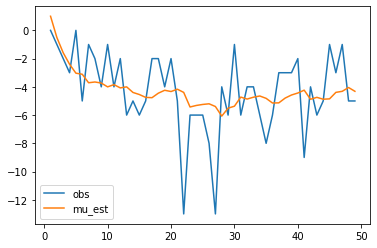

In [17]:
c,a,b,r = res.x
mle_mu_df = skellam_filter(c,a,b,r,Y)
mle_mu_df[['obs','mu_est']].plot()

In [18]:
for index in mle_mu_df.index:
    ci_values = skellam_ci( mle_mu_df.loc[index,'state1'], mle_mu_df.loc[index,'state2'],.95  )
    mle_mu_df.loc[index,'lower_ci'] = ci_values[0]
    mle_mu_df.loc[index,'upper_ci'] = ci_values[1]

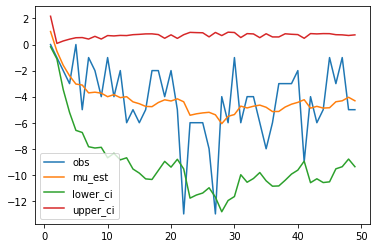

In [20]:
mle_mu_df[['obs','mu_est','lower_ci','upper_ci']].plot()